In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('data/responses.csv')
df.head()

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,...,20.0,176.0,67.0,2.0,female,right handed,secondary school,no,city,block of flats
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,22.0,172.0,59.0,1.0,female,right handed,college/bachelor degree,yes,city,house/bungalow
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,...,20.0,170.0,59.0,1.0,female,right handed,secondary school,no,village,house/bungalow


In [3]:
columns=df.columns.tolist()
print(columns)

['Music', 'Slow songs or fast songs', 'Dance', 'Folk', 'Country', 'Classical music', 'Musical', 'Pop', 'Rock', 'Metal or Hardrock', 'Punk', 'Hiphop, Rap', 'Reggae, Ska', 'Swing, Jazz', 'Rock n roll', 'Alternative', 'Latino', 'Techno, Trance', 'Opera', 'Movies', 'Horror', 'Thriller', 'Comedy', 'Romantic', 'Sci-fi', 'War', 'Fantasy/Fairy tales', 'Animated', 'Documentary', 'Western', 'Action', 'History', 'Psychology', 'Politics', 'Mathematics', 'Physics', 'Internet', 'PC', 'Economy Management', 'Biology', 'Chemistry', 'Reading', 'Geography', 'Foreign languages', 'Medicine', 'Law', 'Cars', 'Art exhibitions', 'Religion', 'Countryside, outdoors', 'Dancing', 'Musical instruments', 'Writing', 'Passive sport', 'Active sport', 'Gardening', 'Celebrities', 'Shopping', 'Science and technology', 'Theatre', 'Fun with friends', 'Adrenaline sports', 'Pets', 'Flying', 'Storm', 'Darkness', 'Heights', 'Spiders', 'Snakes', 'Rats', 'Ageing', 'Dangerous dogs', 'Fear of public speaking', 'Smoking', 'Alcohol',

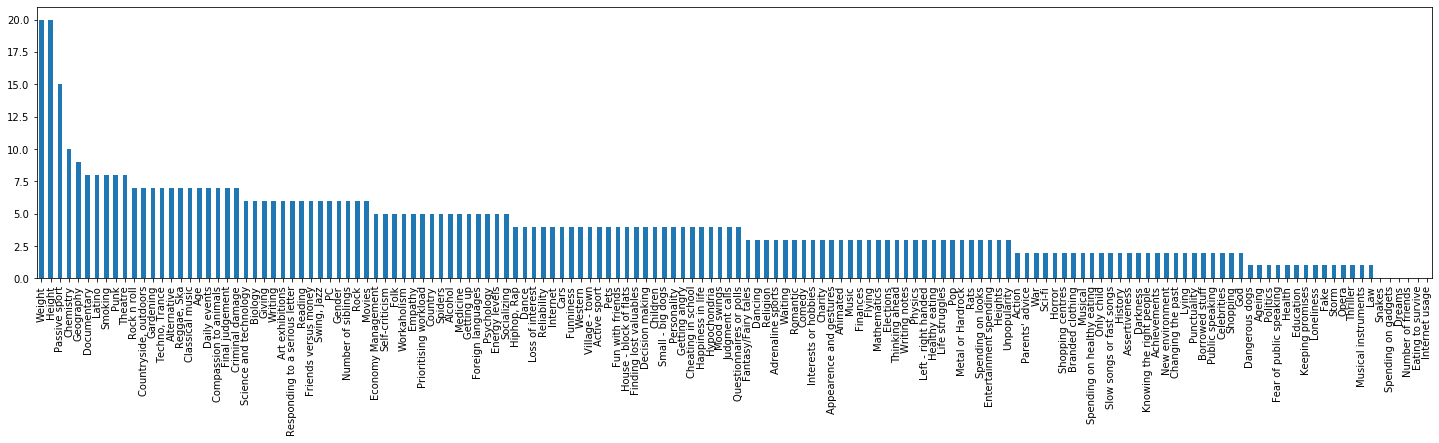

In [4]:
#number of null values per category
nulls = df.isnull().sum().sort_values(ascending=False)
nulls.plot(kind='bar', figsize=(25, 5))

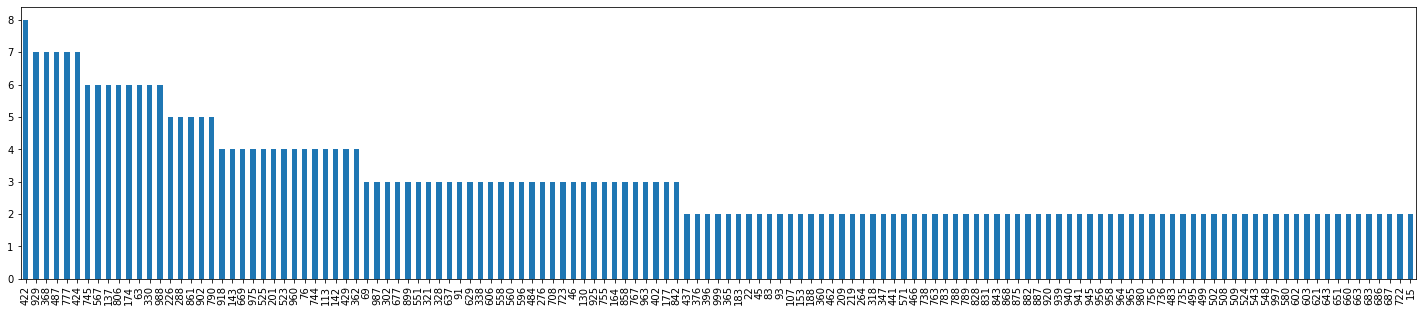

In [5]:
#number of null values per entry (more than 1 missing value)
nulls = df.isnull().sum(axis=1)[df.isnull().sum(axis=1)>1].sort_values(ascending=False)
nulls.plot(kind='bar', figsize=(25, 5))

Prozent female in 0 is 0.5923295454545454
Prozent female in 1 is 0.5878378378378378


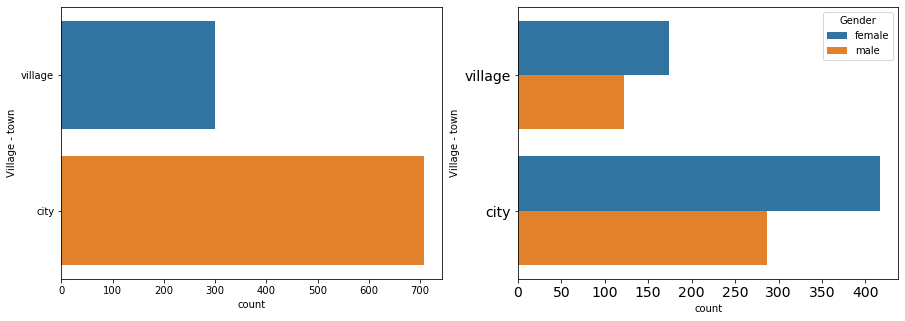

In [6]:
var_of_interest = 'Village - town'
df.dropna(subset=[var_of_interest], inplace=True)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.countplot(y=var_of_interest, data=df, ax=ax[0])
sns.countplot(y=var_of_interest, hue='Gender', data=df, ax=ax[1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

mapping = {var_of_interest: {'city': 0, 'village': 1}}
df.replace(mapping, inplace=True)
mapping_gender = {"Gender": {'male': 0, 'female': 1}}
df.replace(mapping_gender, inplace=True)
for c in range(2):
    print("Prozent female in",c,"is",df.Gender[df.Gender==1][df[var_of_interest]==c].sum()/(len(df.Gender[df.Gender==0][df[var_of_interest]==c])+df.Gender[df.Gender==1][df[var_of_interest]==c].sum()))

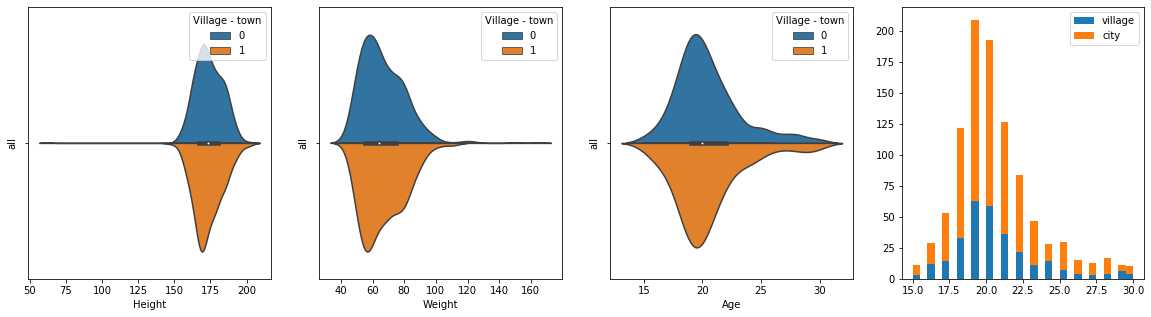

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
df["all"] = ""
data = df.dropna(subset=['Height'])
sns.violinplot(x='Height', y = "all", hue=var_of_interest, data=data, split=True, ax = ax[0]);
data = df.dropna(subset=['Weight'])
sns.violinplot(x='Weight', y = "all", hue=var_of_interest, data=data, split=True, ax = ax[1]);
data = df.dropna(subset=['Age'])
sns.violinplot(x='Age', y = "all", hue=var_of_interest, data=data, split=True, ax = ax[2]);

var_of_int_ser = df[var_of_interest]
plt.hist([df[var_of_int_ser==1].Age.dropna(),df[var_of_int_ser==0].Age.dropna()],
             label=['village','city'], stacked=True, bins=30);
ax[3].legend()

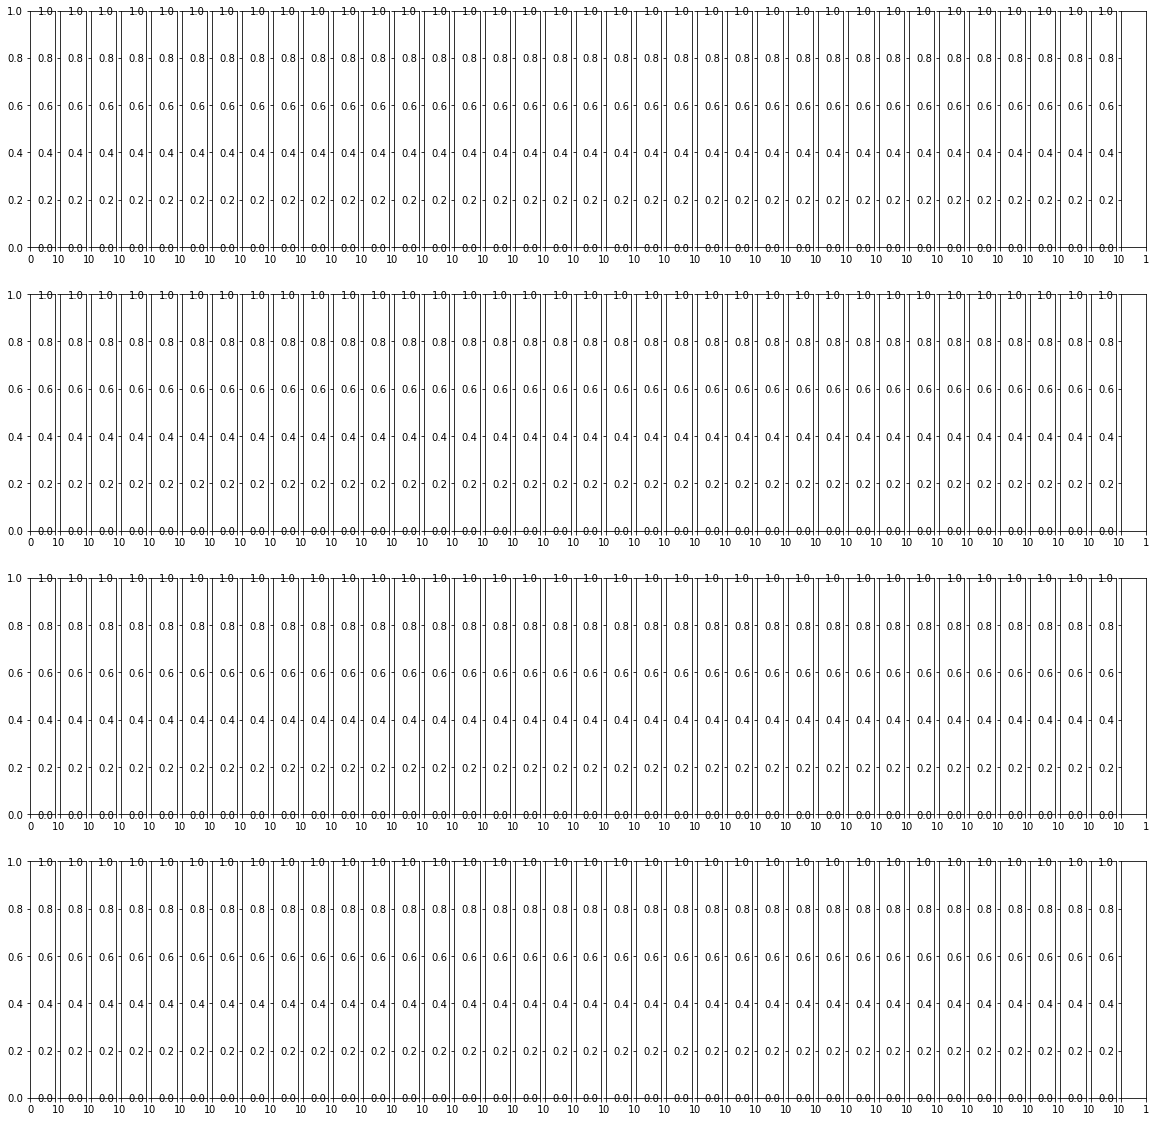

In [10]:
numerics=df.select_dtypes(include=['int64','float64','uint8','int32','bool'])
numeric_columns=numerics.columns.tolist()
numerics["all"] = ""
fig, ax = plt.subplots(nrows=4, ncols=len(columns)//4, figsize=(20,20))
for i in range(len(numeric_columns)):
    data = df.dropna(subset=[numeric_columns[i]])
    try:
        sns.violinplot(x=numeric_columns[i], y = "all", hue=var_of_interest, data=numerics, split=True, ax = ax[i%4])
    except:
        continue
    plt.show()
    ax[i%4].legend()

                             Music  Slow songs or fast songs     Dance  \
Music                     1.000000                  0.099525  0.081408   
Slow songs or fast songs  0.099525                  1.000000  0.193832   
Dance                     0.081408                  0.193832  1.000000   
Folk                      0.031666                 -0.061571  0.064822   
Country                  -0.007410                 -0.071303  0.057273   
...                            ...                       ...       ...   
Height                   -0.070057                  0.086592 -0.001449   
Weight                   -0.130797                  0.119647  0.012694   
Number of siblings       -0.008944                  0.005835  0.002459   
Gender                    0.103000                 -0.079818  0.041535   
Village - town            0.000720                  0.007774  0.063009   

                              Folk   Country  Classical music   Musical  \
Music                     0.031666 -

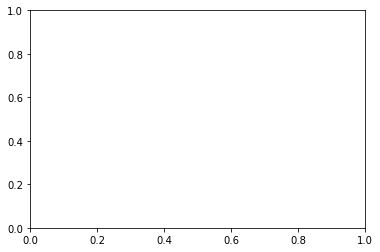

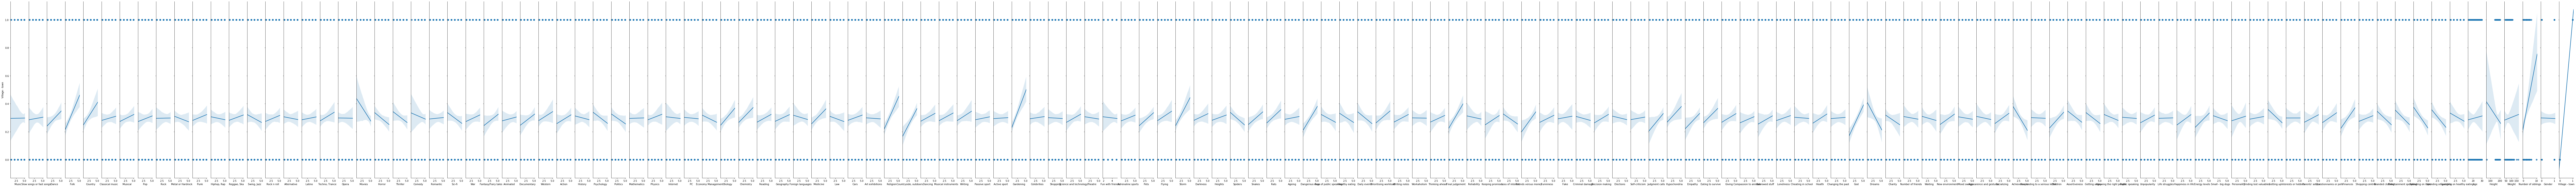

In [19]:
#exploratory analysis of correlations between variables. Don't say anything about causations when inspected like this.
print(numerics.corr())
#revenue and budget seems fairly correlated with a Spearman's correlation coefficent of 0.69 (excluding 0-values for revenue and budget in the records)
print()
#pair plot
fig, ax = plt.subplots()
g=sns.pairplot(data=numerics,y_vars=var_of_interest,x_vars=numeric_columns,kind="reg")
g.fig.set_size_inches(150,15)